<a href="https://colab.research.google.com/github/baussel/Satellite_Detection/blob/main/Image_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First Object Detection Model - Cats and Dogs

Test code to be copied for the real satellite detection model.

## Data Download

In [ ]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Download dataset of cats and dogs, 2000 images
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

--2021-07-14 09:41:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   140MB/s    in 0.5s    

2021-07-14 09:41:40 (140 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
#Save the data in the folder content
import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Data Preparation

In [ ]:
#Installation of modules
!pip install wandb

     |████████████████████████████████| 1.8MB 7.4MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 143kB 51.9MB/s 
     |████████████████████████████████| 174kB 49.3MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=6efbcb7324a0774435489753970805c56a2fb81eb3e9f5c50011a5b690ebe5b7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=36bfb8f5e6c42e81f4d0174a25d92898f4bd7193c66b934bd7b36906e420dd9d
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
#Import of the relevant modules
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

#Connection to Weight and Biases (https://wandb.ai)
import wandb
from wandb.keras import WandbCallback

In [ ]:
#Paramters for the images
img_height = 256
img_width = 256

#Batch_size - Size of used images per step
batch_size = 32

#Image Path
image_path = '/content/cats_and_dogs_filtered'

In [ ]:
#Definition of the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path+"/train",
    #validation_split=0.2,
    #subset="training",
    #seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary",
    color_mode="rgb") #Maybe change to grayscale for satellites

Found 2000 files belonging to 2 classes.


In [ ]:
#Definition of the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path+"/validation",
  #validation_split=0.2,
  #subset="validation",
  #seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="binary",
  color_mode="rgb") #Maybe change to grayscale for satellites

Found 1000 files belonging to 2 classes.


In [ ]:
#Return the class names
class_names = train_ds.class_names
print("Classes:",class_names)

Classes: ['cats', 'dogs']


In [ ]:
print("Shape of the Dataset")
print(train_ds)

Shape of the Dataset
<BatchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.float32)>


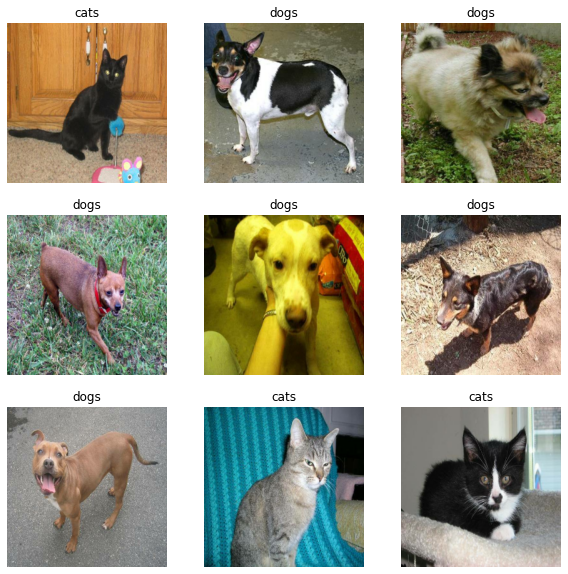

In [ ]:
#Example Images
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1): #Takes the first batch
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Creating the model

In [ ]:
#Definition of the layers of the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #Normalization layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [ ]:
#Compiling of the model, loss function is binary
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Overview over the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)       

## Training of the model

In [ ]:
#Connection to Weights and Biases
#parameters
config = wandb.config
config.learning_rate = 0.01
wandb.init(project='image_classifier_test')

#Number of epochs for the training
epoch_number = 10

#Starting the training and storing the result in 'history'
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epoch_number,
  callbacks=[WandbCallback()])

epoch,9
loss,0.00018
accuracy,1.0
val_loss,2.08617
val_accuracy,0.711
_runtime,156
_timestamp,1626258574
_step,9
best_val_loss,1.67643
best_epoch,2


epoch,▁▂▃▃▄▅▆▆▇█
loss,▂▆█▅▂▁▁▁▁▁
accuracy,█▄▁▆██████
val_loss,▁▃▁▂▄▅▆▇▇█
val_accuracy,▇▁▅▆█▇█▇█▇
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


Epoch 1/10
63/63 [==============================] - 8s 118ms/step - loss: 1.4735e-04 - accuracy: 1.0000 - val_loss: 2.1274 - val_accuracy: 0.7140
Epoch 2/10
63/63 [==============================] - 8s 115ms/step - loss: 1.2641e-04 - accuracy: 1.0000 - val_loss: 2.1494 - val_accuracy: 0.7140
Epoch 3/10
63/63 [==============================] - 7s 105ms/step - loss: 1.1127e-04 - accuracy: 1.0000 - val_loss: 2.1717 - val_accuracy: 0.7140
Epoch 4/10
63/63 [==============================] - 7s 110ms/step - loss: 9.8997e-05 - accuracy: 1.0000 - val_loss: 2.1932 - val_accuracy: 0.7130
Epoch 5/10
63/63 [==============================] - 7s 109ms/step - loss: 8.8729e-05 - accuracy: 1.0000 - val_loss: 2.2137 - val_accuracy: 0.7130
Epoch 6/10
63/63 [==============================] - 7s 109ms/step - loss: 7.9951e-05 - accuracy: 1.0000 - val_loss: 2.2323 - val_accuracy: 0.7120
Epoch 7/10
63/63 [==============================] - 8s 115ms/step - loss: 7.2332e-05 - accuracy: 1.0000 - val_loss: 2.2513 -

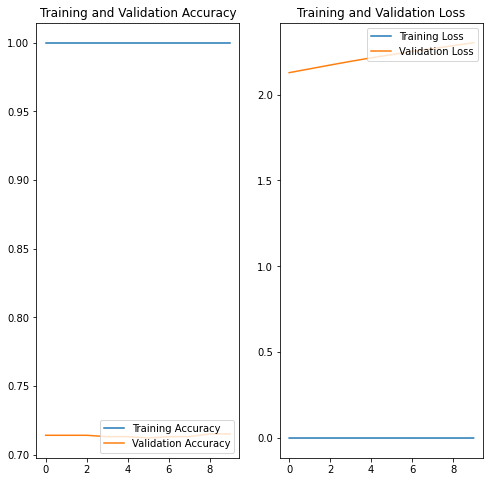

In [ ]:
#Plot the training progress

#Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

#Epochs
epochs_range = range(epoch_number)

#Plot - Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plot - Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction of unknown images

In [ ]:
#Load image
img = keras.preprocessing.image.load_img(
    image_path+"/validation/cats/cat.2018.jpg", 
    target_size=(img_height, img_width))

#Process the image to an array and then to a batch
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#Calculate the (binary) prediction
class_pr = (model.predict(img_array) > 0.5).astype("int32") #For binary prediction
score_pr = model.predict(img_array)
if class_pr == 0:
  score_pr = 1 - score_pr

#Print the result
print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[int(class_pr)], 100 *float(score_pr)))

This image most likely belongs to cats with a 100.00 percent confidence.
